# Homework 1
* Download:
 * http://snap.stanford.edu/data/ca-GrQc.txt.gz
 * http://www-personal.umich.edu/~mejn/netdata/netscience.zip

In [415]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import defaultdict
from itertools import combinations

In [2]:
np.random.seed(2357)

# 1) Network Characteristics [25 points]

One of the goals of network analysis is to find mathematical models that characterize real-world
networks and that can then be used to generate new networks with similar properties. In this
problem, we will explore two famous models—Erdős-Rényi and Small World—and compare them
to real-world data from an academic collaboration network. Note that in this problem all networks
are undirected. You may use the starter code in hw1-q1-starter.py for this problem

### Erdős-Rényi Random graph (G(n, m) random network):
* Generate a random instance of this model by using n = 5242 nodes and picking m = 14484 edges at random. Write code to construct instances of this model, i.e., do not call a SNAP function.

In [3]:
def generate_edge(N):
    u = np.random.randint(N)
    v = np.random.randint(N)
    return u, v

def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Erdos-Renyi graph with N nodes and E edges
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.TUNGraph.New()
    
    for node_id in range(N):
        Graph.AddNode(node_id)
    
    edges = set()
    for _ in range(E):
        u, v = generate_edge(N)
        while ((u, v) in edges) or ((v, u) in edges) or (u == v):
            u, v = generate_edge(N)
        edges.add((u, v))
        Graph.AddEdge(u, v)

    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == E)
    ############################################################################
    return Graph

In [4]:
erdosRenyi = genErdosRenyi(5242, 14484)

### Small-World Random Network:

* Generate an instance from this model as follows: begin with n = 5242 nodes arranged as a ring, i.e., imagine the nodes form a circle and each node is connected to its two direct neighbors (e.g., node 399 is connected to nodes 398 and 400), giving us 5242 edges. Next, connect each node to the neighbors of its neighbors (e.g., node 399 is also connected to nodes 397 and 401). This gives us another 5242 edges. Finally, randomly select 4000 pairs of nodes not yet connected and add an edge between them. In total, this will make m = 5242 · 2 + 4000 = 14484 edges. Write code to construct instances of this model, i.e., do not call a SNAP function.

In [5]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.TUNGraph.New()
    
    for node_id in range(N):
        Graph.AddNode(node_id)
    
    for node_id in range(N-1):
        Graph.AddEdge(node_id, node_id + 1)
    
    Graph.AddEdge(N - 1, 0)
    
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == N)
    ############################################################################
    return Graph


def connectNbrOfNbr(Graph, N=5242):
    """
    :param - Graph: snap.PUNGraph object representing a circle graph on N nodes
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Graph object with additional N edges added by connecting each node
        to the neighbors of its neighbors
    """
    ############################################################################
    # TODO: Your code here!
    for node_id in range(N-2):
        Graph.AddEdge(node_id, node_id + 2)
    Graph.AddEdge(N - 2, 0)
    Graph.AddEdge(N - 1, 1)
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == 2*N)
    ############################################################################
    return Graph


def connectRandomNodes(Graph, M=4000):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :param - M: number of edges to be added

    return type: snap.PUNGraph
    return: Graph object with additional M edges added by connecting M randomly
        selected pairs of nodes not already connected.
    """
    ############################################################################
    # TODO: Your code here!

    N = Graph.GetNodes()
    for _ in range(M):
        u, v = generate_edge(N)
        while (u == v) or Graph.IsEdge(u, v):
            u, v = generate_edge(N)
        Graph.AddEdge(u, v)
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == 2*N + M)
    ############################################################################
    return Graph


def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Small-World graph with N nodes and E edges
    """
    Graph = genCircle(N)
    Graph = connectNbrOfNbr(Graph, N)
    Graph = connectRandomNodes(Graph, 4000)
    return Graph

In [6]:
smallWorld = genSmallWorld(5242, 14484)

### Real-World Collaboration Network:

* Download this undirected network from http://snap.stanford.edu/data/ca-GrQc.txt.gz. Nodes in this network represent authors of research papers on the arXiv in the General Relativity and Quantum Cosmology section. There is an edge between two authors if they have co-authored at least one paper together. Note that some edges may appear twice in the data, once for each direction. Ignoring repeats and self-edges, there are 5242 nodes and 14484 edges. (Note: Repeats are automatically ignored when loading an (un)directed graph with SNAP’s LoadEdgeList function).

In [7]:
def loadCollabNet(path):
    """
    :param - path: path to edge list file

    return type: snap.PUNGraph
    return: Graph loaded from edge list at `path and self edges removed

    Do not forget to remove the self edges!
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.LoadEdgeList(snap.PUNGraph, path, 0, 1)
    
    snap.DelSelfEdges(Graph)
    
    assert (Graph.GetNodes() == 5242) and (Graph.GetEdges() == 14484)
    ############################################################################
    return Graph

In [8]:
collabNet = loadCollabNet("ca-GrQc.txt")

## 1.1) Degree Distribution [12 points]

Generate a random graph from both the Erdős-Rényi (i.e., G(n, m)) and Small-World models and
read in the collaboration network. Delete all of the self-edges in the collaboration network (there
should be 14,484 total edges remaining).
Plot the degree distribution of all three networks in the same plot on a log-log scale. In other words,
generate a plot with the horizontal axis representing node degrees and the vertical axis representing
the proportion of nodes with a given degree (by “log-log scale” we mean that both the horizontal
and vertical axis must be in logarithmic scale). In one to two sentences, describe one key difference
between the degree distribution of the collaboration network and the degree distributions of the
random graph models.

In [9]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    ############################################################################
    # TODO: Your code here!
    X, Y = [], []
    d = defaultdict(int)
    for node in Graph.Nodes():
        out_degree = node.GetOutDeg()
        d[out_degree] += 1
    d = dict(d)
    X, Y = zip(*sorted(d.items(), key=lambda x: x[0]))
    X, Y = list(X), [y/Graph.GetNodes() for y in Y]
    ############################################################################
    return X, Y


def Q1_1():
    """
    Code for HW1 Q1.1
    """
    erdosRenyi = genErdosRenyi(5242, 14484)
    smallWorld = genSmallWorld(5242, 14484)
    collabNet = loadCollabNet("ca-GrQc.txt")

    x_erdosRenyi, y_erdosRenyi = getDataPointsToPlot(erdosRenyi)
    plt.loglog(x_erdosRenyi, y_erdosRenyi, color='y', label='Erdos Renyi Network')

    x_smallWorld, y_smallWorld = getDataPointsToPlot(smallWorld)
    plt.loglog(x_smallWorld, y_smallWorld, linestyle='dashed', color='r', label='Small World Network')

    x_collabNet, y_collabNet = getDataPointsToPlot(collabNet)
    plt.loglog(x_collabNet, y_collabNet, linestyle='dotted', color='b', label='Collaboration Network')

    plt.xlabel('Node Degree (log)')
    plt.ylabel('Proportion of Nodes with a Given Degree (log)')
    plt.title('Degree Distribution of Erdos Renyi, Small World, and Collaboration Networks')
    plt.legend()
    plt.show()

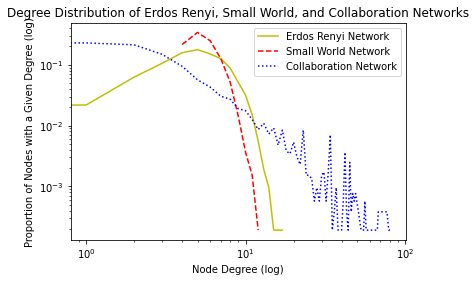

In [10]:
Q1_1()

## 1.2) Clustering Coefficient [13 points]

Compute and report the average clustering coefficient of the three networks. For this question,
write your own implementation to compute the clustering coefficient, instead of using a built-in
SNAP function.
Which network has the largest clustering coefficient? In one to two sentences, explain. Think about
the underlying process that generated the network.

In [11]:
def calcClusteringCoefficientSingleNode(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: local clustering coeffient of Node
    """
    ############################################################################
    # TODO: Your code here!
    C = 0.0
    k = Node.GetDeg()
    if k >= 2:
        e = 0
        for i in range(k):
            for j in range(i, k):
                u = Node.GetNbrNId(i)  # Returns ID of NodeN-th neighboring node 
                v = Node.GetNbrNId(j)
                if Graph.IsEdge(u, v):
                    e += 1
        C = 2*e / (k*(k-1))
    ############################################################################
    return C

def calcClusteringCoefficient(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: clustering coeffient of Graph
    """
    ############################################################################
    # TODO: Your code here! If you filled out calcClusteringCoefficientSingleNode,
    #       you'll probably want to call it in a loop here
    C = 0.0
    for node in Graph.Nodes():
        C += calcClusteringCoefficientSingleNode(node, Graph)
    C /= Graph.GetNodes()
    ############################################################################
    return C

def Q1_2():
    """
    Code for Q1.2
    """
    C_erdosRenyi = calcClusteringCoefficient(erdosRenyi)
    C_smallWorld = calcClusteringCoefficient(smallWorld)
    C_collabNet = calcClusteringCoefficient(collabNet)

    print('Clustering Coefficient for Erdos Renyi Network: %f' % C_erdosRenyi)
    print('Clustering Coefficient for Small World Network: %f' % C_smallWorld)
    print('Clustering Coefficient for Collaboration Network: %f' % C_collabNet)


# Execute code for Q1.2
Q1_2()

Clustering Coefficient for Erdos Renyi Network: 0.001608
Clustering Coefficient for Small World Network: 0.283923
Clustering Coefficient for Collaboration Network: 0.529636


# 2) Structural Roles: Rolx and ReFex [25 points]

In this problem, we will explore the structural role extraction algorithm Rolx and its recursive feature extraction method ReFex. As part of this exploration, we will work with a dataset rep-resenting a scientist co-authorship network, which can be dowloaded at http://www-personal.umich.edu/~mejn/netdata/netscience.zip. 1 Although the graph is weighted, for simplicity we treat it as undirected and unweighted in this problem.

Feature extraction consists of two steps; we first extract basic local features from every node, and we subsequently aggregate them along graph edges so that global features are also obtained. Collectively, feature extraction constructs a matrix V ∈ R n×f where for each of the n nodes we have f features to cover local and global information. Rolx extracts node roles from that matrix.

In [13]:
G = snap.TUNGraph.Load(snap.TFIn("hw1-q2.graph"))

## 2.1) Basic Features [5 points]

In [393]:
def cos_sim(x, y):
    dot_p = np.dot(x, y)
    x_norm = np.linalg.norm(x)  # l-2 norm
    y_norm = np.linalg.norm(y)
    if (x_norm == 0) or (y_norm == 0):
        return 0
    return dot_p / (x_norm * y_norm)


def getNodeSimilars(node_id, id2vec, top=-1, identity=False):
    node_vec = id2vec[node_id, :]
    if identity:
        sim_score = np.array([
            cos_sim(node_vec, vec) for vec in id2vec
        ])
    else:
        sim_score = np.array([
            cos_sim(node_vec, vec) if i != node_id else -1 for i, vec in enumerate(id2vec)
        ])
    sim_nodes = np.argsort(sim_score)[::-1]
    if top > 0:
        sim_nodes = sim_nodes[:top]
    
    return sim_nodes, sim_score[sim_nodes]

def nodeDegree(Node, Graph):
    """the degree of v, i.e., deg(v)"""
    return Node.GetDeg()

def getEgoNetNodes(Node):
    nodes = set({Node.GetId()})
    k = Node.GetDeg()
    for i in range(k):
        nodes.add(Node.GetNbrNId(i))
    return nodes

def nodeEgoNetNbEdges(Node, Graph):
    """the number of edges in the egonet of v,
       where egonet of v is defined as the subgraph of G induced by v and its neighborhood
    """
    nodes = getEgoNetNodes(Node)

    nb_edges = 0
    for node_i, node_j in combinations(nodes, 2):
        if G.IsEdge(node_i, node_j):
            nb_edges += 1
    return nb_edges

def nodeEgoNetOutNbEdges(Node, Graph):
    """the number of edges that connect the egonet of v and the rest of the graph,
       i.e., the number of edges that enter or leave the egonet of v.
    """
    nodes = getEgoNetNodes(Node)

    nb_edges_out = 0
    for node in nodes:
        Node = Graph.GetNI(node)
        for nn in Node.GetOutEdges():
            if nn not in nodes:
                nb_edges_out += 1
    return nb_edges_out

def compute_features(Graph):
    id2vec = {}

    for Node in G.Nodes():
        deg_feat = nodeDegree(Node, G)
        ergonet_edges_feat = nodeEgoNetNbEdges(Node, G)
        ergonet_out_feat = nodeEgoNetOutNbEdges(Node, G)
        id2vec[Node.GetId()] = np.array([deg_feat, ergonet_edges_feat, ergonet_out_feat])
    
    assert (id2vec[9] <= 10).all()
    feats = np.array([id2vec[i] for i in id2vec])
    assert (feats[9,:] <= 10).all()
    return feats


def Q2_1():
    feats = compute_features(G)
    sim_nodes, sim_score = getNodeSimilars(9, feats, top=5)
    print(f'Feat Node 9: {feats[9]}\nClosest nodes: {sim_nodes} \nScore: {sim_score}')

In [394]:
Q2_1()

Feat Node 9: [ 6 10  1]
Closest nodes: [ 415  286  288 1336 1054] 
Score: [0.99961575 0.99634368 0.99634368 0.99611824 0.99611824]


## 2.2) Recursive Features [8 points]

In this next step, we recursively generate some more features. We use mean and sum as aggregation
functions. Initially, we have a feature vector Ṽ u ∈ R 3 for every node u. In the first iteration, we concatenate
the mean of all u’s neighbors’ feature vectors to Ṽ u , and do the same for sum, i.e.,

In [395]:
def get_nn(Node):
    nodes = set()
    k = Node.GetDeg()
    for i in range(k):
        nodes.add(Node.GetNbrNId(i))
    return list(nodes)

def recursive_features(Graph, k=2):
    V = compute_features(Graph)
    for _ in range(k):
        nb_feat = V.shape[1]
        V1 = np.zeros((Graph.GetNodes(), nb_feat * 3))
        V1[:, :nb_feat] = V.copy()
        for Node in Graph.Nodes():
            neighbors = get_nn(Node)
            if neighbors != []:
                node_id = Node.GetId()
                nn_feats = V[neighbors, :]
                mean_feat = np.mean(nn_feats, axis=0)
                sum_feat = np.sum(nn_feats, axis=0)
                V1[node_id, nb_feat:] = np.concatenate([mean_feat, sum_feat])
        V = V1.copy()
    return V

def Q2_2():
    feats = recursive_features(G, k=2)
    sim_nodes, sim_score = getNodeSimilars(9, feats, top=5)
    print(f'Feat Node 9: {feats[9]}\n\nClosest nodes: {sim_nodes} \n\nScore: {sim_score}')

In [396]:
Q2_2()

Feat Node 9: [  6.          10.           1.           2.5          4.33333333
   4.          15.          26.          24.           2.5
   4.33333333   4.           4.31944444   7.34722222   2.38888889
  10.16666667  17.5          6.5         15.          26.
  24.          25.91666667  44.08333333  14.33333333  61.
 105.          39.        ]

Closest nodes: [973 537 415 496  24] 

Score: [0.99598488 0.994613   0.99372844 0.99228397 0.99224132]


* There is one common node: 415
* Nodes changes because of the aggregations, in each iteration we know information about one path step forward.

## 2.3) Role Discovery [12 points]

In this part, we explore more about the graph according to the recursive feature vectors of nodes and node similarity.

(a) Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and any other node in the graph (according to their recursive feature vectors). Note here that the x-axis is cosine similarity with node 9, and the y-axis is the number of nodes. [3 points]

According to the histogram, can you spot some groups / roles? How many can you spot? (Clue:
look for the spikes! ) [2 points]

In [397]:
feats = recursive_features(G, k=2)
sim_nodes, sim_score = getNodeSimilars(9, feats, identity=True)

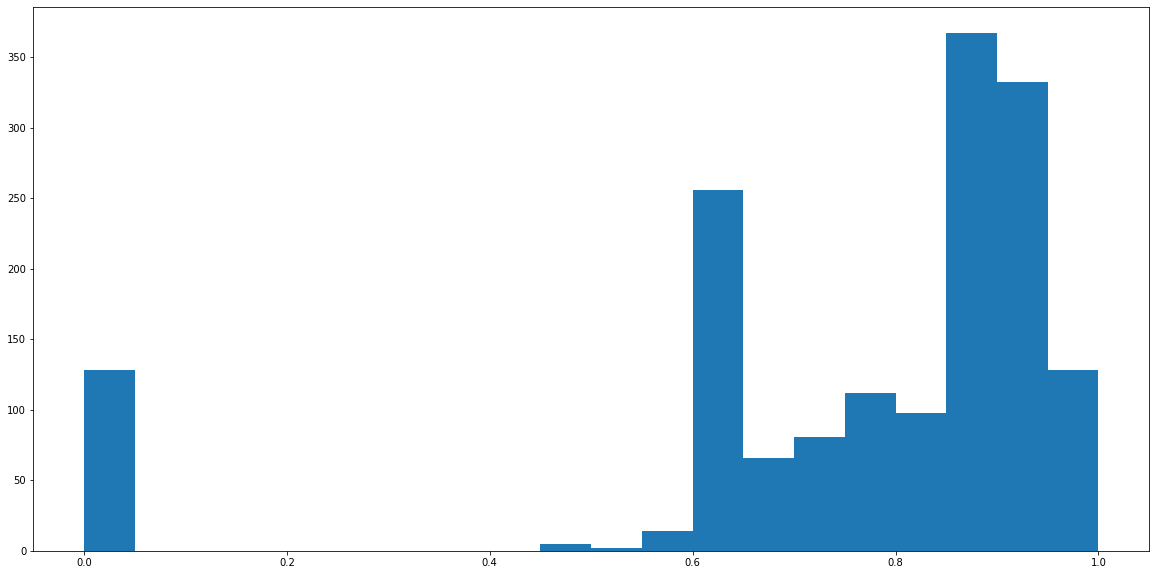

In [400]:
fig = plt.figure(figsize=[20, 10])
fig = plt.hist(sim_score, bins=20)

According to the histogram, can you spot some groups / roles? How many can you spot? (Clue:
look for the spikes! ) [2 points]

* We can see 5 groups of nodes based on node 9 similarity

(b) For these groups / roles in the cosine similarity histogram, take one node u from each group to
examine the feature vector, and draw the subgraph of the node based on its feature vector. You
can draw the subgraph by hand, or you can use libraries such as networkx or graphviz.
For these drawings, you should use the local features for u, and pay attention to the features
aggregated from its 1-hop neighbors, but feel free to ignore further features if they are difficult to
incorporate. Also, you should not draw nodes that are more than 3-hops away from u. [6 points]
Briefly argue how different structural roles are captured in 1-2 sentences. [1 point]

In [424]:
node_g1 = int(np.where(sim_score < 0.05)[0][0])
node_g2 = int(np.where((sim_score > 0.60) & (sim_score < 0.65))[0][0])
node_g3 = int(np.where((sim_score > 0.85) & (sim_score < 0.90))[0][0])
node_g4 = int(np.where((sim_score > 0.90) & (sim_score < 0.95))[0][0])

In [425]:
for i, gp in enumerate([node_g1,node_g2,node_g3,node_g4], 1):
    print(f'Group{i}: {gp}\nFeat: {feats[gp]}\n')

Group1: 1461
Feat: [  2.           3.          13.           8.5         16.5
  26.5         17.          33.          53.           8.5
  16.5         26.5          6.02083333  11.92361111  26.47222222
  51.         101.         224.5         17.          33.
  53.          12.04166667  23.84722222  52.94444444 102.
 202.         449.        ]

Group2: 1184
Feat: [ 2.  3.  0.  2.  3.  0.  4.  6.  0.  2.  3.  0.  2.  3.  0.  4.  6.  0.
  4.  6.  0.  4.  6.  0.  8. 12.  0.]

Group3: 460
Feat: [  3.           6.           2.           3.66666667   7.
   6.          11.          21.          18.           3.66666667
   7.           6.           4.24444444   8.53333333   7.66666667
  16.33333333  33.33333333  30.33333333  11.          21.
  18.          12.73333333  25.6         23.          49.
 100.          91.        ]

Group4: 128
Feat: [  5.          12.          11.           6.          15.8
  11.2         30.          79.          56.           6.
  15.8         11.2          6.18

In [491]:
def draw_subgraph(Graph, feats, node_id, nb_feats=-1):
    g = nx.Graph()
    
    Node = G.GetNI(node_id)
    nodes = getEgoNetNodes(Node)
    
    for node in nodes:
        g.add_node(node)

    for i in nodes:
        for j in nodes:
            if Graph.IsEdge(i,j):
                sim = cos_sim(feats[i], feats[j])
                if nb_feats > 0:
                    sim = cos_sim(feats[i,:nb_feats], feats[j,:nb_feats])

                g.add_edge(i, j, weight=round(sim, 4))
    
    nx.draw(g, with_labels=True, font_weight='bold')
    labels = nx.get_edge_attributes(g, 'weight')
    pos = nx.spring_layout(g)
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

    plt.title(f'{node_id}')
    plt.show()

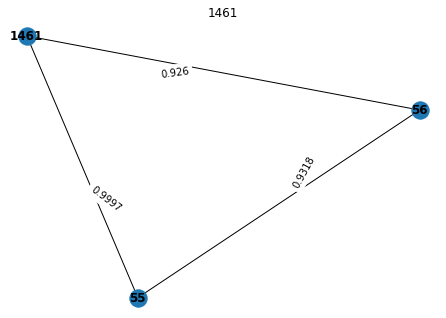

In [498]:
draw_subgraph(G, feats, node_g1)

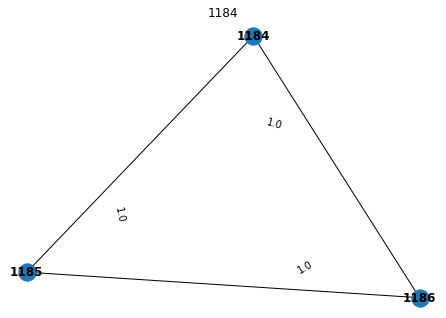

In [500]:
draw_subgraph(G, feats, node_g2)

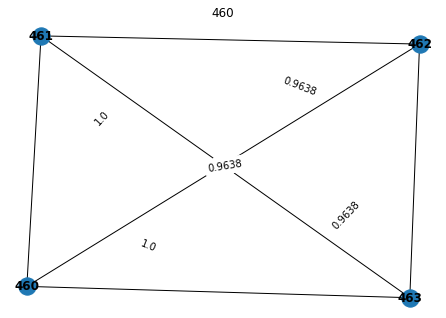

In [501]:
draw_subgraph(G, feats, node_g3)

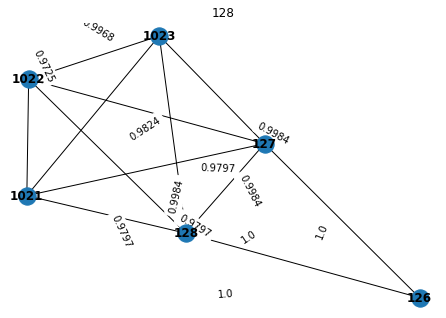

In [502]:
draw_subgraph(G, feats, node_g4)

# 3) Community detection using the Louvain algorithm [25 points]

Note: For this question, assume all graphs are undirected and weighted.
Communities are a fundamental aspect of several networks. However, it is often not an easy task
to come up with an “optimal” grouping of nodes into communities. Through this problem, we will
explore some properties of the Louvain algorithm for community detection (so named because the
authors were all affiliated with the University of Louvain in Belgium at some point). The original
paper from Blondel et al. is available here: https://arxiv.org/pdf/0803.0476.pdf. If you are
stuck on this question at any point please refer to the paper; there is a good chance that you will
find what you seek there.
We will first explore the idea of modularity. The modularity of a weighted graph is a measure that
compares the density of edges within a community to the density of edges between communities.
Formally, we define the modularity Q for a given graph as follows:
    
Each pass of the algorithm has two phases, and proceeds as follows:
* Phase 1 (Modularity Optimization): Start with each node in its own community.
• For each node i, go over all the neighbors j of i. Calculate the change in modularity when i
is moved from its present community to j‘s community. Find the neighbor j m for which this
process causes the greatest increase in modularity, and assign i to j m ‘s community (break
ties arbitrarily). If there is no positive increase in modularity during this process, keep i in
its original community.
• Repeat the above process for each node (going over nodes multiple times if required) until
there is no further maximization possible (that is, each node remains in its community). This
is the end of Phase 1.
* Phase 2 (Community Aggregation): Once Phase 1 is done, we contract the original
graph G to a new graph H. Each community found in G after Phase 1 becomes a node in H.
The weights of edges in between 2 nodes in H are given by the sums of the weights between
the respective 2 communities in G. The weights of edges within a community in G sum up
to form a self-edge of the same weight in H (be careful while calculating self-edge weights,
note that you will have to go once over each original node within the community in G). This
is the end of Phase 2. Phase 1 and Phase 2 together make up a single pass of the algorithm.

* Repeat Phase 1 and Phase 2 again on H and keep proceeding this way until no further
improvement is seen (you will reach a point where each node in the graph stays in its orig-
inal community to maximize modularity). The final modularity value is a heuristic for the
maximum modularity of the graph.

## 3.1 Modularity gain when an isolated node moves into a community [4 points]

Prove that the modularity gain seen when i merges with C

$ \Delta Q = Q_{f} - Q_{i} $

by definition:

$ Q_{i} = \frac{1}{2m} [\sum_{in} - (\sum_{tot})^2  - \frac{k_{i}^2}{2m}] $

$ Q_{i} =  \frac{\sum_{in}}{2m} - \frac{\sum_{tot}}{2m}^2  - (\frac{k_{i}}{2m})^2 $

by definition:

$ Q_{f} = \frac{1}{2m} [\sum_{in} + \frac{k_{i,in}}{2} - \frac{(\sum_{tot} + k_{i})^2}{2m}] $

$ Q_{f} =  \frac{\sum_{in} + \frac{k_{i,in}}{2}}{2m}  - (\frac{\sum_{tot} + k_{i}}{2m})^2 $

## 3.2 Louvain algorithm on a 16 node network [10 points]

Consider the graph G (Figure 3), with 4 cliques of 4 nodes each arranged in a ring. Assume all the
edges have same weight value 1. There exists exactly one edge between any two adjacent cliques.
We will manually inspect the results of the Louvain algorithm on this network. The first phase of
modularity optimization detects each clique as a single community (giving 4 communities in all).
After the community aggregation phase, the new network H will have 4 nodes.

What is the weight of any edge between two distinct nodes in H? [1 point]
* $ 1 $

What is the weight of any self-edge in H? [2 point]
* $ 3 * 4 = 12 $

What is the modularity of H (with each node in its own community)? The easiest way to calculate modularity would be to directly apply the definition from 1 to H (also holds for upcoming questions of this type). [2 points]
* $ 2m = \sum A_{ij} = 4 * 12 + 4 * 2 = 48 + 8 = 56 $
* $ Q_{H} = \frac{1}{2m} (12 - \frac{14^2}{2m}) * 4 \approx 0.6071$

What is the weight of any edge between two distinct nodes in J? [1 point]
* $ 2$

What is the weight of any self-edge in J? [2 point]
* $ 26 $

What is the modularity of J (with each node in its own community)? [2 points]
* $ 2m = \sum A_{ij} = 2 * 26 + 2 * 2 = 52 + 4 = 56 $
* $ Q_{J} = \frac{1}{2m} (26 - \frac{28^2}{2m}) * 2 \approx 0.4285$


As expected, the modularity of J is less than the modularity of H.

## 3.3 Louvain algorithm on a 128 node network [10 points]

Now consider a larger version of the same network, with 32 cliques of 4 nodes each (arranged in a ring as earlier); call this network G big . Again, assume all the edges have same weight value 1, and there exists exactly one edge between any two adjacent cliques. The first phase of modularity optimization, as expected, detects each clique as a single community. After aggregation, this forms a new network H big with 32 nodes.

What is the weight of any edge between two distinct nodes in $ H_{big} $? [1 point]
* 1

What is the weight of any self-edge in $ H_{big} $ ? [2 point]
* 12

What is the modularity of $ H_{big} $ (with each node in its own community)? [2 points]
* $ 2m = \sum A_{ij} = 32 * 12 + 32 * 2 = 384 + 64 =  448 $
* $ Q_{H_{big}} = \frac{1}{2m} (12 - \frac{14^2}{2m}) * 32 \approx 0.8258$

What is the weight of any edge between two distinct nodes in $ J_{big}$ ? [1 point]
* 2

What is the weight of any self-edge in $ J_{big}$ ? [2 point]
* 26

What is the modularity of $ J_{big} $ (with each node in its own community)? [2 points]
* $ 2m = \sum A_{ij} = 16 * 26 + 16 * 2 = 416 + 32 = 448 $
* $ Q_{J_{big}} = \frac{1}{2m} (26 - \frac{28^2}{2m}) * 16 \approx 0.8660$


## 3.4 What just happened? [1 point]

Explain (in a few lines) why you think the algorithm behaved the way it did for the larger network (you don’t need to prove anything rigorously, a rough argument will do). In other words, what might have caused modularity to be maximized with an “unintuitive” community grouping for the larger network?

* https://arxiv.org/pdf/physics/0607100.pdf

# 4) Spectral clustering [25 points]